In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mkdir ~/.kaggle

In [ ]:
 # ! cp kaggle.json ~/.kaggle/

In [ ]:
!cp /content/drive/MyDrive/kaggle_dataset/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                title                                      size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------  ----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
syedanwarafridi/vehicle-sales-data                 Vehicle Sales Data                         19MB  2024-02-21 20:16:17          17328        307  1.0              
sudarshan24byte/online-food-dataset                Online Food Dataset                         3KB  2024-03-02 18:50:30           7009        121  0.9411765        
arnavvvvv/spotify-music                            Top Spotify Songs                          47KB  2024-03-06 05:20:29           5373         74  1.0              
bhavikjikadara/student-study-performance           Student Study Performance                   9KB  2024-03-07 06:14:09           4257         72  1.0              
nbroad/gem

In [ ]:
!kaggle datasets download -d imsparsh/flowers-dataset

 94% 193M/205M [00:01<00:00, 122MB/s]
100% 205M/205M [00:02<00:00, 103MB/s]


In [ ]:
!unzip flowers-dataset.zip

Archive:  flowers-dataset.zip
  inflating: LICENSE.txt             
  inflating: Testing_set_flower.csv  
  inflating: sample_submission.csv   
  inflating: test/Image_1.jpg        
  inflating: test/Image_10.jpg       
  inflating: test/Image_100.jpg      
  inflating: test/Image_101.jpg      
  inflating: test/Image_102.jpg      
  inflating: test/Image_103.jpg      
  inflating: test/Image_104.jpg      
  inflating: test/Image_105.jpg      
  inflating: test/Image_106.jpg      
  inflating: test/Image_107.jpg      
  inflating: test/Image_108.jpg      
  inflating: test/Image_109.jpg      
  inflating: test/Image_11.jpg       
  inflating: test/Image_110.jpg      
  inflating: test/Image_111.jpg      
  inflating: test/Image_112.jpg      
  inflating: test/Image_113.jpg      
  inflating: test/Image_114.jpg      
  inflating: test/Image_115.jpg      
  inflating: test/Image_116.jpg      
  inflating: test/Image_117.jpg      
  inflating: test/Image_118.jpg      
  inflating: test/Im

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import torchvision

# PyTorch Data Loading and Preprocesing Libraries
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from PIL import Image

# PyTorch Model Implementation Libraries
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

In [ ]:
data_dir = '/content/drive/MyDrive/kaggle_dataset/kaggle.json'
train_data_path = '/content/train'
test_data_path = '/content/test'

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
train_dataset = datasets.ImageFolder(root=train_data_path, # target folder of images
                                     transform=data_transforms['train'], # transforms to perform on data (images)
                                     target_transform=None)
print(f"Train data:\n{train_dataset}")


Train data:
Dataset ImageFolder
    Number of datapoints: 2746
    Root location: /content/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
def load_and_preprocess_image(image_path):
  """
  This function loads an image from the given path, applies the same transformations used for the training data,
  and returns a tensor representation.
  """
  # Open the image using PIL
  img = Image.open(image_path)

  # Apply the same transformations used for training data
  img = transforms.Resize(256)(img)
  img = transforms.CenterCrop(224)(img)
  img = transforms.ToTensor()(img)
  img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
  # Return the image as a tensor
  return img.unsqueeze(0)

In [ ]:
test_images = []
test_labels = []  # Fill with -1 as placeholder for unlabeled data

for filename in os.listdir(test_data_path):
  # Check if it's an image file
  if filename.endswith(".jpg") or filename.endswith(".png"):
    # Get the image path
    image_path = os.path.join(test_data_path, filename)

    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)

    # Squeeze the image tensor to remove the extra dimension
    image = torch.squeeze(image, 0)

    # Add the image and placeholder label to the lists
    test_images.append(image)
    test_labels.append(-1)

In [ ]:
test_images[0].shape, test_images[0].dtype

(torch.Size([3, 224, 224]), torch.float32)

In [ ]:
print(f'Class Names: {train_dataset.classes}')
sample_img, sample_idx = train_dataset[0]
print(f'Sample Image Shape: {sample_img.shape}')
print(f'Sample Image type: {sample_img.dtype}')
print(f'Sample Index {sample_idx}')

Class Names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Sample Image Shape: torch.Size([3, 224, 224])
Sample Image type: torch.float32
Sample Index 0


In [ ]:
batch_size = 32

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

len(train_loader)

86

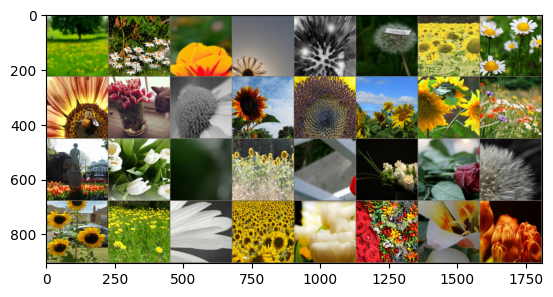

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cpu


In [ ]:
def initialize_resnet(num_classes, feature_extract=True):
    # Load pre-trained ResNet model
    model_ft = models.resnet50(weights=models.resnet.ResNet50_Weights.DEFAULT)  # Specify weights

    # Freeze the weights of the pre-trained layers
    if feature_extract:
        for param in model_ft.parameters():
            param.requires_grad = False

    # Replace the fully connected layer with a new one (unfrozen by default)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    return model_ft

# Number of classes in the dataset
num_classes = len(train_dataset.classes)

# Initialize the ResNet model for transfer learning
resnet_model = initialize_resnet(num_classes)

# Print the model architecture
#print(resnet_model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 55.2MB/s]


In [ ]:
model = resnet_model
# Move the model to GPU
model.to(device)
# Create a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
model.to(device)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct_predictions = 0
    total_train_samples = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute training evaluation metrics
        train_loss += loss.item() * inputs.size(0)
        train_correct_predictions += (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_train_samples += inputs.size(0)

    # Compute average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_correct_predictions / total_train_samples

    print(f"Epoch {epoch+1}/{num_epochs} - Average Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

Epoch 1/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 1/10 - Average Training Loss: 0.9033, Training Accuracy: 0.7389


Epoch 2/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 2/10 - Average Training Loss: 0.5202, Training Accuracy: 0.8536


Epoch 3/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 3/10 - Average Training Loss: 0.4179, Training Accuracy: 0.8769


Epoch 4/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 4/10 - Average Training Loss: 0.3710, Training Accuracy: 0.8926


Epoch 5/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 5/10 - Average Training Loss: 0.3379, Training Accuracy: 0.9006


Epoch 6/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 6/10 - Average Training Loss: 0.3186, Training Accuracy: 0.8984


Epoch 7/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 7/10 - Average Training Loss: 0.2884, Training Accuracy: 0.9162


Epoch 8/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 8/10 - Average Training Loss: 0.2853, Training Accuracy: 0.9119


Epoch 9/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 9/10 - Average Training Loss: 0.2569, Training Accuracy: 0.9228


Epoch 10/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 10/10 - Average Training Loss: 0.2627, Training Accuracy: 0.9177


Number of test images: 924
Predicted class distribution:
daisy: 133
dandelion: 241
rose: 144
sunflower: 206
tulip: 200


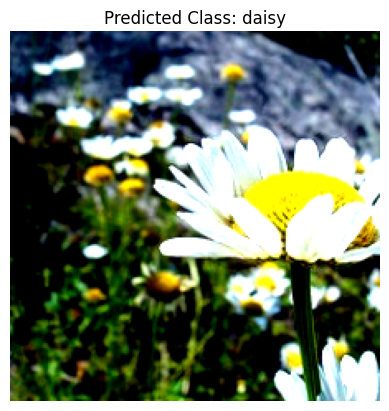

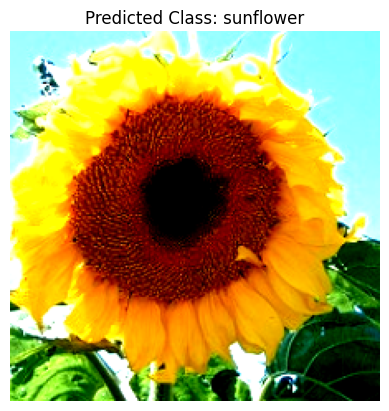

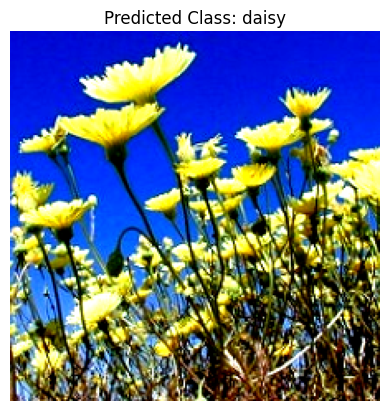

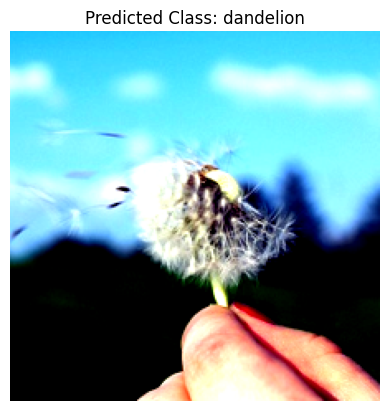

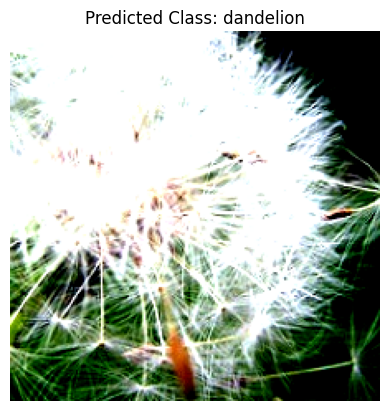

In [ ]:
import matplotlib.pyplot as plt

def evaluate_model(model, test_images, test_labels, class_names):
    """
    This function evaluates the model on the test data, prints some basic metrics, and visualizes some images with their predicted classes.
    """
    model.eval()  # Set the model to evaluation mode

    # Initialize variables to track predictions and true labels (optional)
    predicted_labels = []
    true_labels = []  # This will be filled with -1s for unlabeled data

    with torch.no_grad():
        for image in test_images:
            # Forward pass
            image = image.to(device)
            image = image.unsqueeze(0)
            output = model(image)  # Add batch dimension
            _, predicted = torch.max(output.data, 1)

            # Store predictions and true labels (optional)
            predicted_labels.append(predicted.item())
            true_labels.append(-1)  # Placeholder for unlabeled data

    # Since you don't have true labels, traditional metrics like accuracy cannot be calculated.
    # However, you can still print some basic information about the predictions:

    # Print the number of images
    print(f"Number of test images: {len(test_images)}")

    # Print the predicted class distribution (optional)
    class_counts = np.bincount(predicted_labels)
    print(f"Predicted class distribution:")
    for i, count in enumerate(class_counts):
        print(f"{class_names[i]}: {count}")

    # Visualize some images along with their predicted classes
    num_images_to_visualize = 5  # Choose the number of images to visualize
    for i in range(num_images_to_visualize):
        image = test_images[i]  # Get the i-th test image
        predicted_class_index = predicted_labels[i]  # Get the predicted class index for the i-th image

        # Convert the PyTorch tensor to a NumPy array and transpose the dimensions
        # Reverse normalization (assuming mean=0.5, std=0.5 for each channel)
        image = image.cpu().numpy().transpose(1, 2, 0)  # Convert to NumPy and transpose dimensions
        image = (image * 0.5) + 0.5  # Rescale to [0, 1] range
        image = np.clip(image, 0, 1)  # Clip values to [0, 1] in case of overflow

        # Plot the image
        plt.figure()
        plt.imshow(image)
        plt.title(f"Predicted Class: {class_names[predicted_class_index]}")
        plt.axis('off')
        plt.show()

    # Save predicted labels to a CSV file for submission on Kaggle
    submission_df = pd.DataFrame({'predictions': [class_names[i] for i in predicted_labels]})
    submission_df.to_csv('submission.csv', index=False)

# After defining the testing loop, call it with your model, test data, and class names:
evaluate_model(model, test_images, test_labels, class_names=['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])